In [ ]:
import numpy as np
import pandas as pd
import copy
import time
from tqdm import tqdm
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
from torchvision import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path ="/content/drive/MyDrive/Bird Species Classification/manasa"


In [ ]:
def get_data_loaders(dataset_path, batch_size, train=True):
  
    transform = transforms.Compose([transforms.ToTensor()])
    # Create the dataset using ImageFolder from torchvision.datasets.
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

    if train:
        # Calculate the lengths of the training and validation sets.
        train_len = int(0.8 * len(dataset))
        valid_len = len(dataset) - train_len

        # Split the dataset into training and validation sets.
        train_data, val_data = random_split(dataset, [train_len, valid_len])

        # Create data loaders for the training and validation sets.
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        return train_loader, len(train_data)
    else:
        test_len = int(0.5 * len(dataset))
        valid_len = len(dataset) - test_len

        # Split the dataset into test and validation sets.
        test_data, val_data = random_split(dataset, [test_len, valid_len])

        # Create data loaders for the test and validation sets.
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # Return the validation and test loaders, and the lengths of the validation and test data.
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
def get_classes(dataset_path):
    dataset = datasets.ImageFolder(root=dataset_path)
    return dataset.classes



In [ ]:
import os
import shutil
from torchvision import datasets, transforms

# 1. Define paths
dataset_dir = "/content/drive/MyDrive/Bird Species Classification/manasa"  # Your main dataset directory
images_dir = os.path.join(dataset_dir, 'CUB_200_2011', 'images')  # Where the images are originally stored
train_dir = os.path.join(dataset_dir, 'train')  # Where training images will be placed
val_dir = os.path.join(dataset_dir, 'val')    # Where validation images will be placed

# 2. Create train/val directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# 5. Update your dataset_path to point to the train or val directory
# when calling get_data_loaders
dataset_path_train = train_dir
dataset_path_val = val_dir

(train_loader, train_data_len) = get_data_loaders(dataset_path_train, 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path_val, 64, train=False)/''

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

31
77
77


In [ ]:

print(train_data_len, test_data_len, valid_data_len)

7836 4898 4898


In [ ]:
def get_classes(data_dir):
 all_data = datasets.ImageFolder(data_dir)
 return all_data.classes

In [ ]:
from torchvision import transforms
from torchvision.transforms import Resize
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations including resizing and converting to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()
])

# Load the dataset
train_dataset = ImageFolder(root='/content/drive/MyDrive/Bird Species Classification/manasa', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


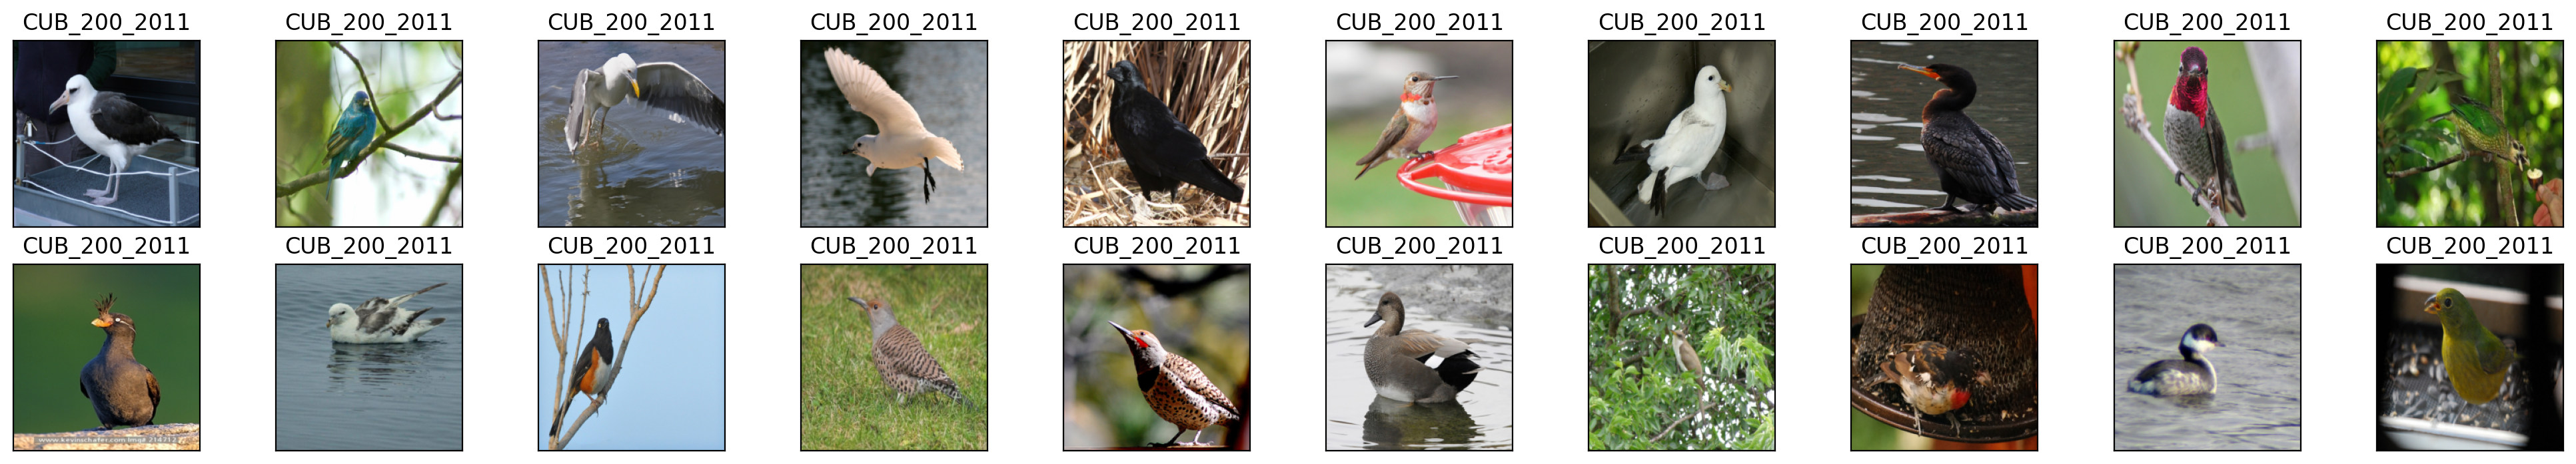

In [ ]:

dataiter = iter(train_loader)

images, labels = next(dataiter)

images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    # Indent the following line to be inside the for loop
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
#model torch.hub.load('facebookresearch/deit:main', 'resmlp 12, pretrained-True)
torch.backends.cudnn.benchmark = True
model= torchvision.models.efficientnet_b0(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 66.9MB/s]


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get in_features before redefining the classifier
n_inputs = model.classifier[1].in_features  # Use the original model to get this value

for param in model.parameters():
    param.requires_grad = False

# Now redefine the classifier
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)
model = model.to(device)

print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=1, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
# Change 'Adamw' to 'AdamW'
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)
#optimizer optim.SGD(model.classifier.parameters(), lr=0.01, momentum 0.9, nesterov=True)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.96)
training_history = {'accuracy': [], 'loss': []}
validation_history = {'accuracy': [], 'loss': []}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Use num_epochs from the function parameters
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # ... rest of your training loop ...
                #zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # This line was incorrectly indented
                    loss = criterion(outputs, labels)
                #backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss/dataset_sizes [phase]
                epoch_acc = running_corrects.double() / dataset_sizes [phase]

                # Moved the code from ipython-input-30-af69622e2611 inside the train_model function
                if phase == 'train':
                    training_history['accuracy'].append(epoch_acc)
                    training_history['loss'].append(epoch_loss)
                elif phase == 'val':
                    validation_history['accuracy'].append(epoch_acc)
                    validation_history['loss'].append(epoch_loss)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                #deep copy the model.
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

  model_fit=train_model(model, criterion, optimizer, step_scheduler, num_epochs=11)


In [ ]:
def predict(model, filepath, show_img=False, url=False):
    """
    Predicts the class of an image.

    Args:
        model: The trained model.
        filepath: The path to the image file or the Google Drive file ID.
        show_img: A boolean indicating whether to display the image.
        url: A boolean indicating whether the filepath is a URL or Google Drive file ID.

    Returns:
        The predicted class of the image.
    """
    if url:
        # For Google Drive files, you need to use the Google Drive API or download the file locally.
        # Here's an example of downloading the file:
        !pip install gdown
        import gdown
        #filepath is assumed to be the Google Drive file ID
        url = 'https://drive.google.com/uc?id=' + filepath
        output = 'downloaded_image.jpg'  # Choose a local filename
        gdown.download(url, output, quiet=False)
        im = Image.open(output)  # Open the downloaded file

    else:
        im = Image.open("https:///content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/001.Black_footed_Albatross.jpg")



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Required Libraries
!pip install requests
!pip install Pillow

from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import os

# Define global classes (replace this with your actual class names)
classes = ["Black-footed Albatross", "Other Bird Class"]  # Example class names

def apply_test_transforms(image):
    """
    Applies transformations to the image for testing.

    Args:
        image: The input image.

    Returns:
        The transformed image as a tensor.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

def predict(model, filepath, show_img=False):
    """
    Predicts the class of an image.

    Args:
        model: The trained model.
        filepath: The path to the image file.
        show_img: A boolean indicating whether to display the image.

    Returns:
        The predicted class of the image.
    """
    try:
        # Load the image from a local path
        im = Image.open(filepath)

        if show_img:
            plt.imshow(im)
            plt.axis('off')
            plt.show()

        # Apply transformations and make predictions
        im_as_tensor = apply_test_transforms(im)
        minibatch = torch.stack([im_as_tensor])
        if torch.cuda.is_available():
            minibatch = minibatch.cuda()
        pred = model(minibatch)
        _, classnum = torch.max(pred, 1)
        return classes[classnum.item()]  # Convert tensor to Python integer
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Directory containing images
image_dir = "/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images"

# Example: Iterate through all images and predict
model = None  # Replace with your trained model
for image_name in os.listdir(image_dir):
    filepath = os.path.join(image_dir, image_name)
    if os.path.isfile(filepath):  # Ensure it's a file
        print(f"Processing image: {image_name}")
        predicted_class = predict(model, filepath, show_img=True)
        print(f"Predicted Class for {image_name}: {predicted_class}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Use num_epochs from the function parameters
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # ... rest of your training loop ...
                #zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # This line was incorrectly indented
                    loss = criterion(outputs, labels)
                #backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss/dataset_sizes [phase]
                epoch_acc = running_corrects.double() / dataset_sizes [phase]

                # Moved the code from ipython-input-30-af69622e2611 inside the train_model function
                if phase == 'train':
                    training_history['accuracy'].append(epoch_acc)
                    training_history['loss'].append(epoch_loss)
                elif phase == 'val':
                    validation_history['accuracy'].append(epoch_acc)
                    validation_history['loss'].append(epoch_loss)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                #deep copy the model.
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
from torchvision import transforms

def apply_test_transforms(image):
    """
    Applies transformations to the image for testing.

    Args:
        image: The input image.

    Returns:
        The transformed image as a tensor.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
from torchvision import datasets, transforms

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths to your training and validation data
# Make sure these paths are correct!
train_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/train'
val_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/val'

# Create datasets
# Wrap in a try-except block to catch potential errors
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)  # Assign val_dataset here
    print(f"Training dataset: {len(train_dataset)} images")
    print(f"Validation dataset: {len(val_dataset)} images")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure the paths to your training and validation directories are correct and that Google Drive is mounted.")
    # If FileNotFoundError, set val_dataset to None to avoid further errors
    val_dataset = None

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# Check if val_dataset was created before creating val_loader
if val_dataset is not None:
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
else:
    print("Validation data loader not created due to missing validation dataset.")
    val_loader = None  # or handle appropriately

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/Bird Species Classification/manasa/train'
Please make sure the paths to your training and validation directories are correct and that Google Drive is mounted.
Validation data loader not created due to missing validation dataset.


In [ ]:
# This code snippet was originally a file path representation and not executable Python code.
# It has been commented out to avoid the IndentationError.
"""
/content/drive/MyDrive/Bird Species Classification/manasa/train/
    class_1/
        image1.jpg
        image2.jpg
    class_2/
        image1.jpg
        image2.jpg
/content/drive/MyDrive/Bird Species Classification/manasa/val/
    class_1/
        image1.jpg
        image2.jpg
    class_2/
        image1.jpg
        image2.jpg
"""

'\n/content/drive/MyDrive/Bird Species Classification/manasa/train/\n    class_1/\n        image1.jpg\n        image2.jpg\n    class_2/\n        image1.jpg\n        image2.jpg\n/content/drive/MyDrive/Bird Species Classification/manasa/val/\n    class_1/\n        image1.jpg\n        image2.jpg\n    class_2/\n        image1.jpg\n        image2.jpg\n'

In [ ]:
train_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/train'
val_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/val'


In [ ]:
from torchvision import datasets, transforms

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize datasets
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    print(f"Training dataset: {len(train_dataset)} images")
    print(f"Validation dataset: {len(val_dataset)} images")
except FileNotFoundError as e:
    print(f"Error: {e}")


Error: Couldn't find any class folder in /content/drive/MyDrive/Bird Species Classification/manasa/train.


In [ ]:
import os
import shutil

# Path to your 'train' directory (adjust this if necessary)
train_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/train'
val_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/val'

# Create class folders in the 'train' and 'val' directories if they don't exist
def organize_images_into_folders(directory):
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            # Extract class name from the file (adjust this logic based on your filename pattern)
            class_name = filename.split('_')[0]  # Assuming class name is before the first underscore in the filename

            # Create a folder for the class if it doesn't exist
            class_folder = os.path.join(directory, class_name)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

            # Move the file into the class folder
            shutil.move(os.path.join(directory, filename), os.path.join(class_folder, filename))

# Organize both the 'train' and 'val' directories
organize_images_into_folders(train_dir)
organize_images_into_folders(val_dir)

print("Images have been organized into class folders.")



Images have been organized into class folders.


In [ ]:
# This code snippet was originally a file path representation and not executable Python code.
# It has been commented out to avoid the IndentationError.
"""
/train/
    class_1/
        image1.jpg
        image2.jpg
    class_2/
        image3.jpg
        image4.jpg
"""

'\n/train/\n    class_1/\n        image1.jpg\n        image2.jpg\n    class_2/\n        image3.jpg\n        image4.jpg\n'

In [ ]:
!ls '/content/drive/MyDrive/Bird Species Classification/manasa/train'
!ls '/content/drive/MyDrive/Bird Species Classification/manasa/val'


In [ ]:
import os
import shutil

# Path to your dataset directory (adjust this if necessary)
dataset_dir = '/content/drive/MyDrive/Bird Species Classification/manasa'

# Path to the images directory
images_dir = os.path.join(dataset_dir, 'CUB_200_2011', 'images')

# Path to the training and validation directories
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

# Create the training and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get a list of all class names
class_names = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]

# Split the images into training and validation sets
for class_name in class_names:
    class_dir = os.path.join(images_dir, class_name)
    images = os.listdir(class_dir)
    num_images = len(images)
    num_train = int(0.8 * num_images)  # 80% for training

    # Create class folders in training and validation directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move images to the appropriate folders
    for i, image in enumerate(images):
        src_path = os.path.join(class_dir, image)
        if i < num_train:
            dst_path = os.path.join(train_dir, class_name, image)
        else:
            dst_path = os.path.join(val_dir, class_name, image)
        shutil.copy(src_path, dst_path)  # Use shutil.copy to avoid moving

print("Images have been organized into class folders.")

Images have been organized into class folders.


In [ ]:
import os

# Path to the train and validation directories
train_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/train'
val_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/val'

# Check the structure
print("Training Classes:", os.listdir(train_dir))
print("Validation Classes:", os.listdir(val_dir))


Training Classes: ['002.Laysan_Albatross', '001.Black_footed_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '006.Least_Auklet', '008.Rhinoceros_Auklet', '005.Crested_Auklet', '007.Parakeet_Auklet', '014.Indigo_Bunting', '012.Yellow_headed_Blackbird', '009.Brewer_Blackbird', '013.Bobolink', '011.Rusty_Blackbird', '010.Red_winged_Blackbird', '016.Painted_Bunting', '015.Lazuli_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '021.Eastern_Towhee', '020.Yellow_breasted_Chat', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '028.Brown_Creeper', '026.Bronzed_Cowbird', '025.Pelagic_Cormorant', '027.Shiny_Cowbird', '032.Mangrove_Cuckoo', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '036.Northern_Flicker', '034.Gray_crowned_Rosy_Finch', '033.Yellow_billed_Cuckoo', '038.Great_Crested_Flycatcher', '035.Purple_Finch', '037.Acadian_Flycatcher', '041.Scissor_tailed_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Fly

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescale validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'
)


Found 3554 images belonging to 210 classes.
Found 904 images belonging to 210 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 632ms/step - accuracy: 0.0166 - loss: 5.6958 - val_accuracy: 0.0166 - val_loss: 4.5540
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 585ms/step - accuracy: 0.0130 - loss: 4.6233 - val_accuracy: 0.0144 - val_loss: 4.3269
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 73s 619ms/step - accuracy: 0.0160 - loss: 4.4720 - val_accuracy: 0.0354 - val_loss: 4.2408
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 579ms/step - accuracy: 0.0275 - loss: 4.3779 - val_accuracy: 0.0542 - val_loss: 4.1719
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 570ms/step - accuracy: 0.0286 - loss: 4.2953 - val_accuracy: 0.0619 - val_loss: 4.0097
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 574ms/step - accuracy: 0.0332 - loss: 4.2008 - val_accuracy: 0.0564 - val_loss: 3.9751
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 573ms/step - accuracy: 0.0379 - loss: 4.1482 - val_accuracy: 0.0531 - val_loss: 3.9572
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 67s 571ms/step - accuracy: 0.0392 - loss: 4.1060 - val

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.0823 - loss: 3.7959
Validation Accuracy: 0.09
Validation Loss: 3.80


In [ ]:
#Visualizing the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

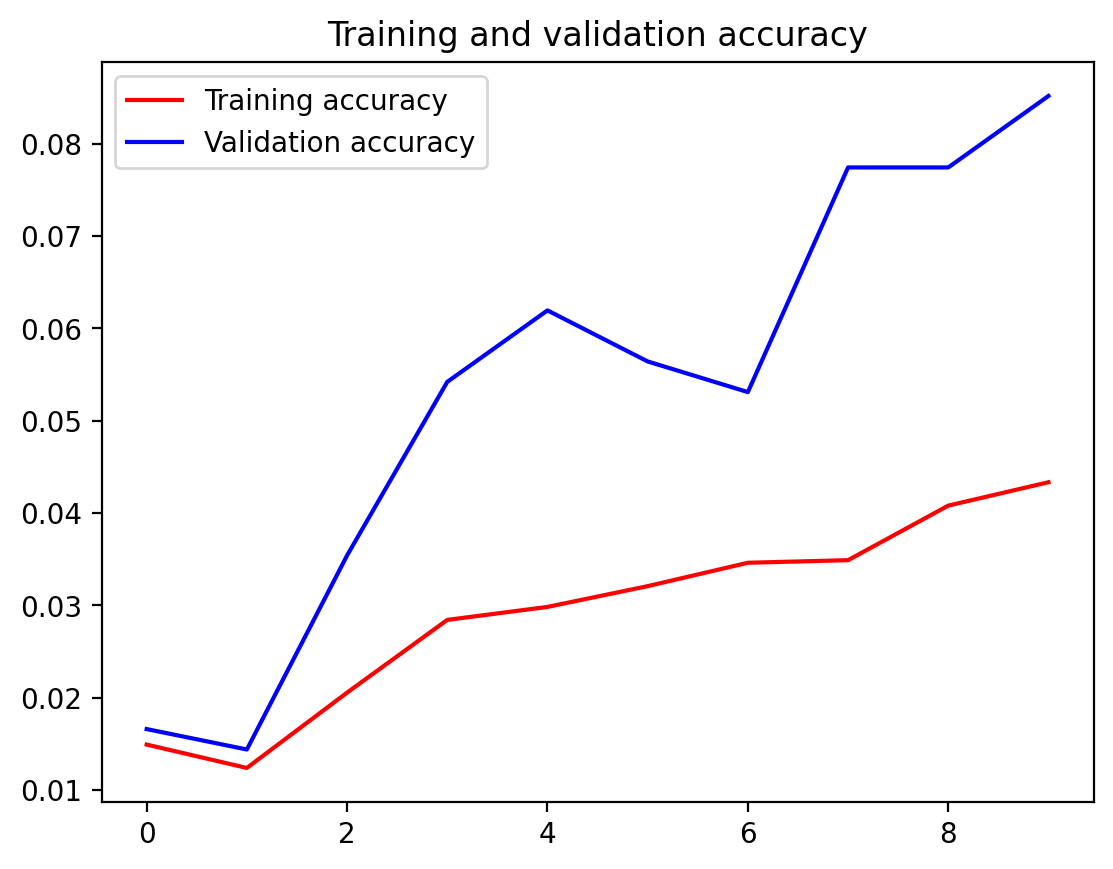

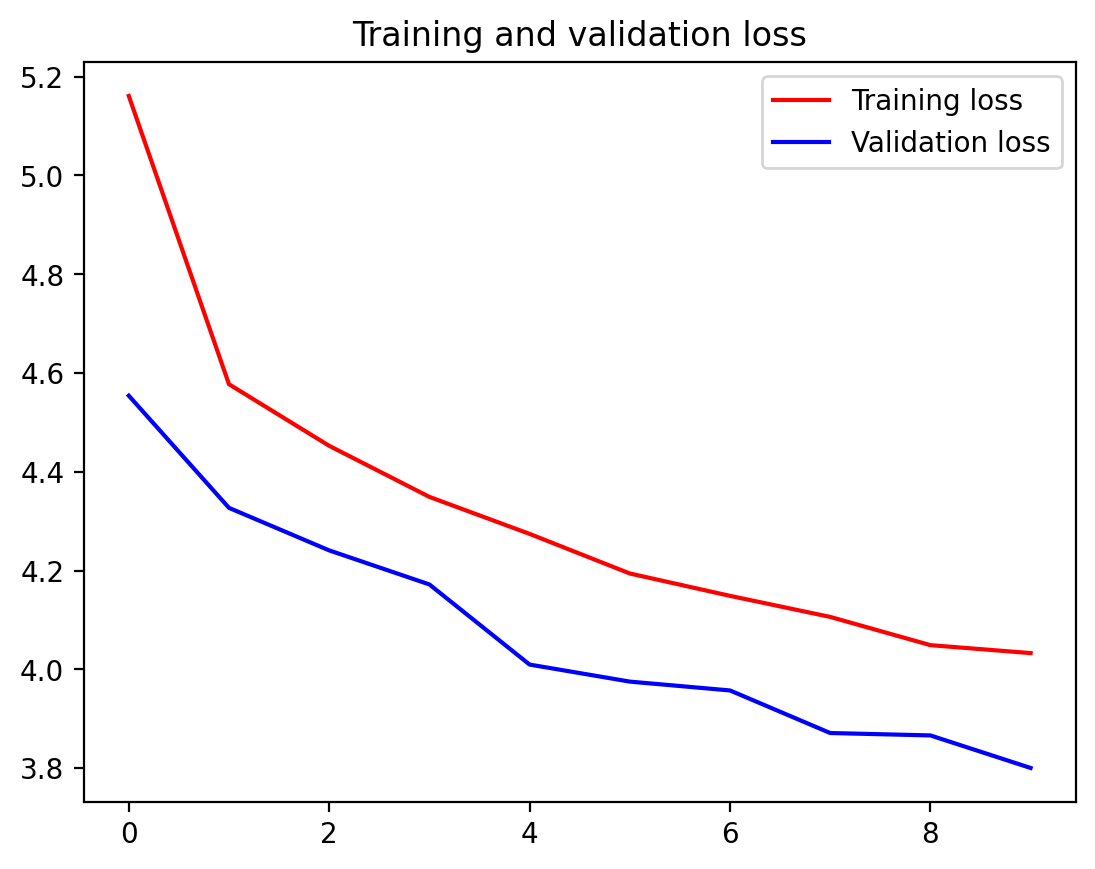

In [ ]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


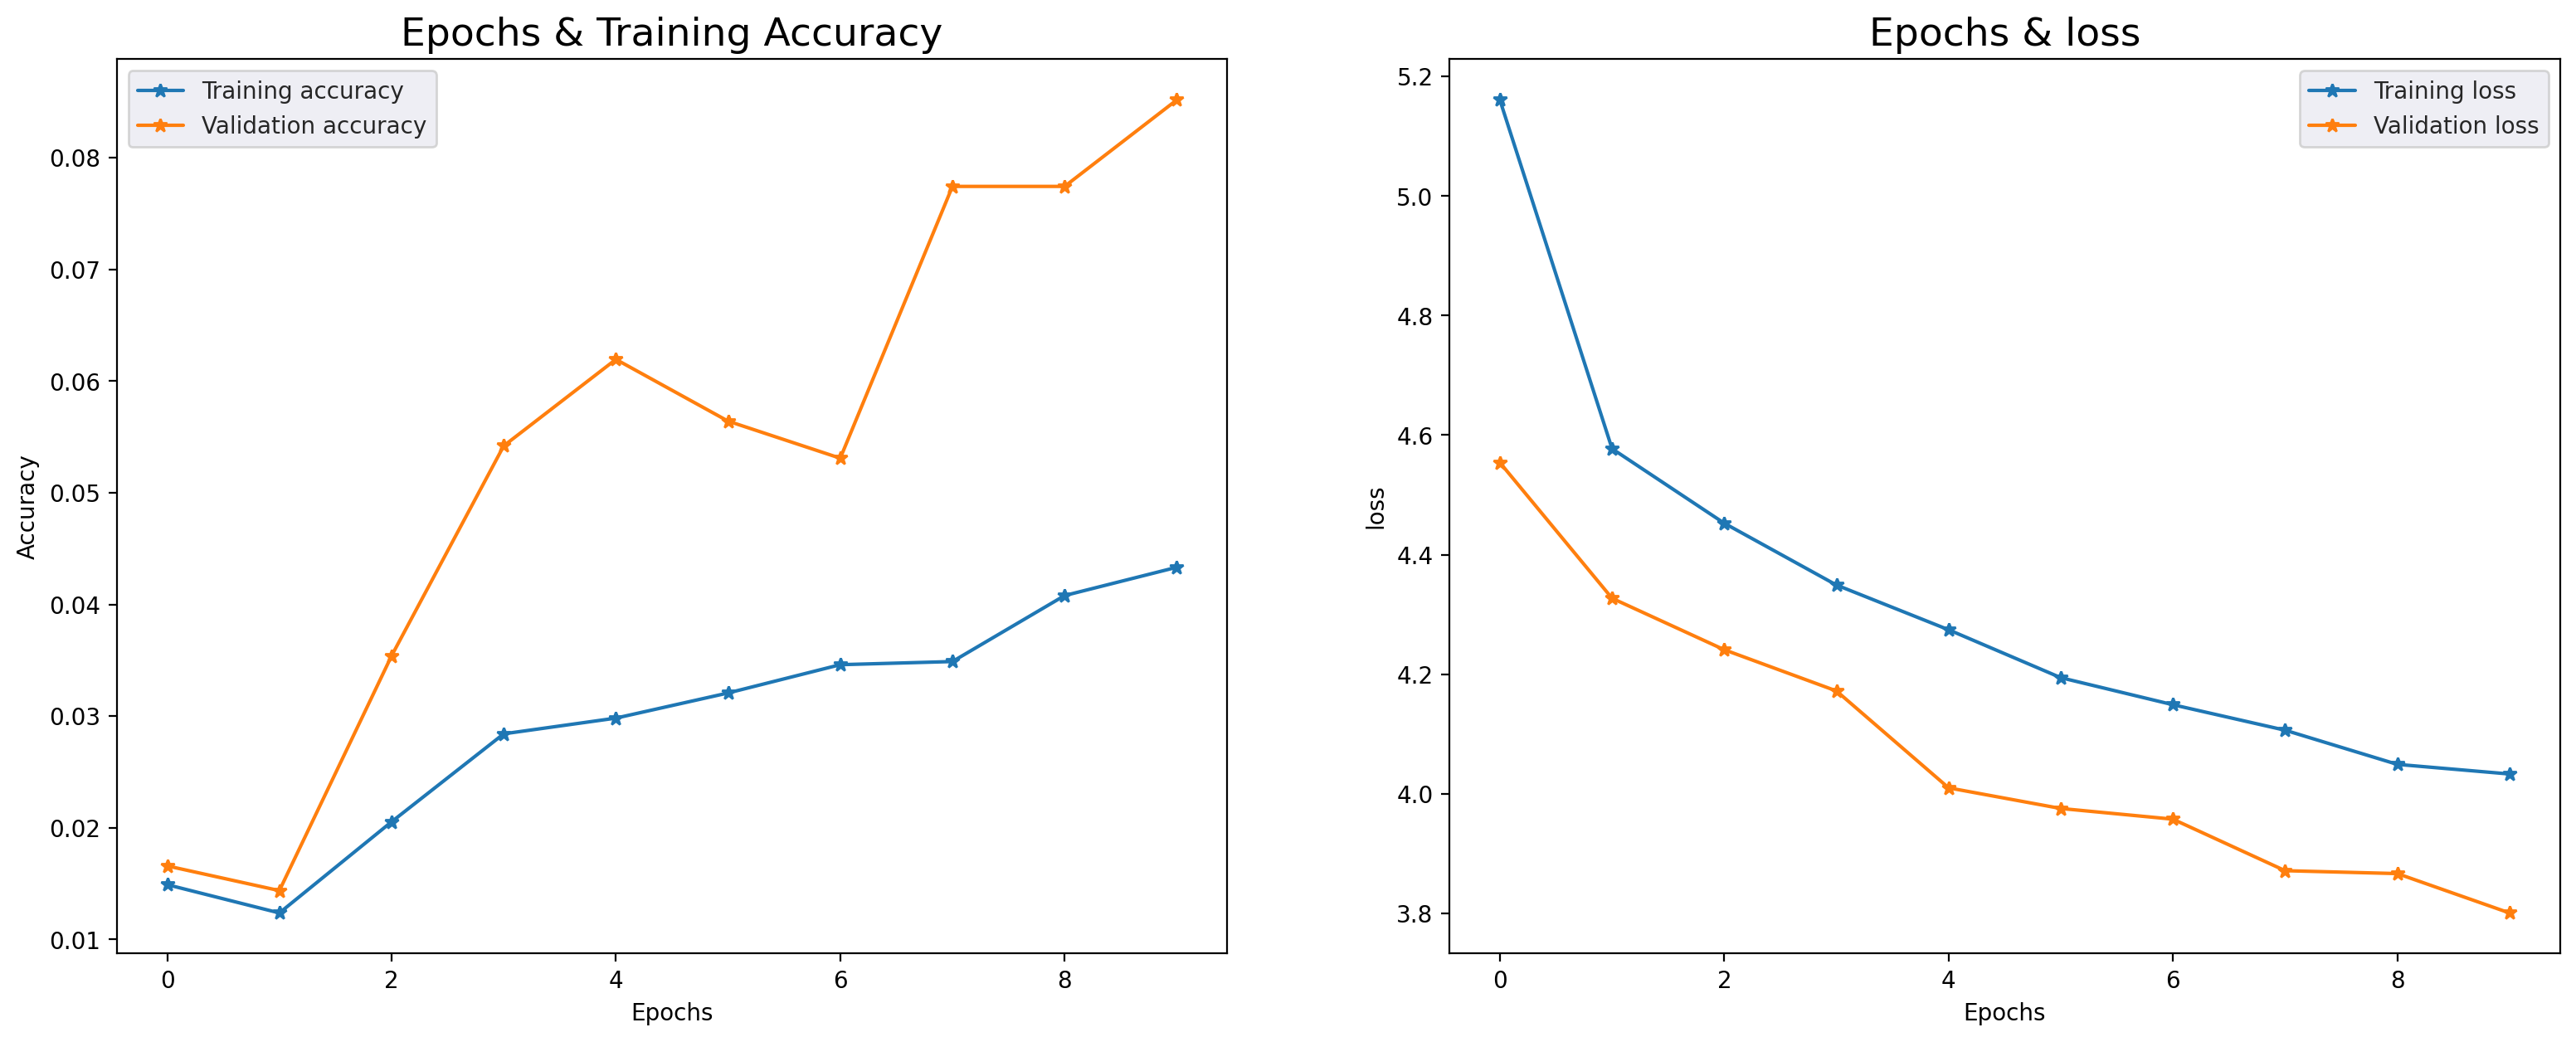

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

In [ ]:
model.save('/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5')


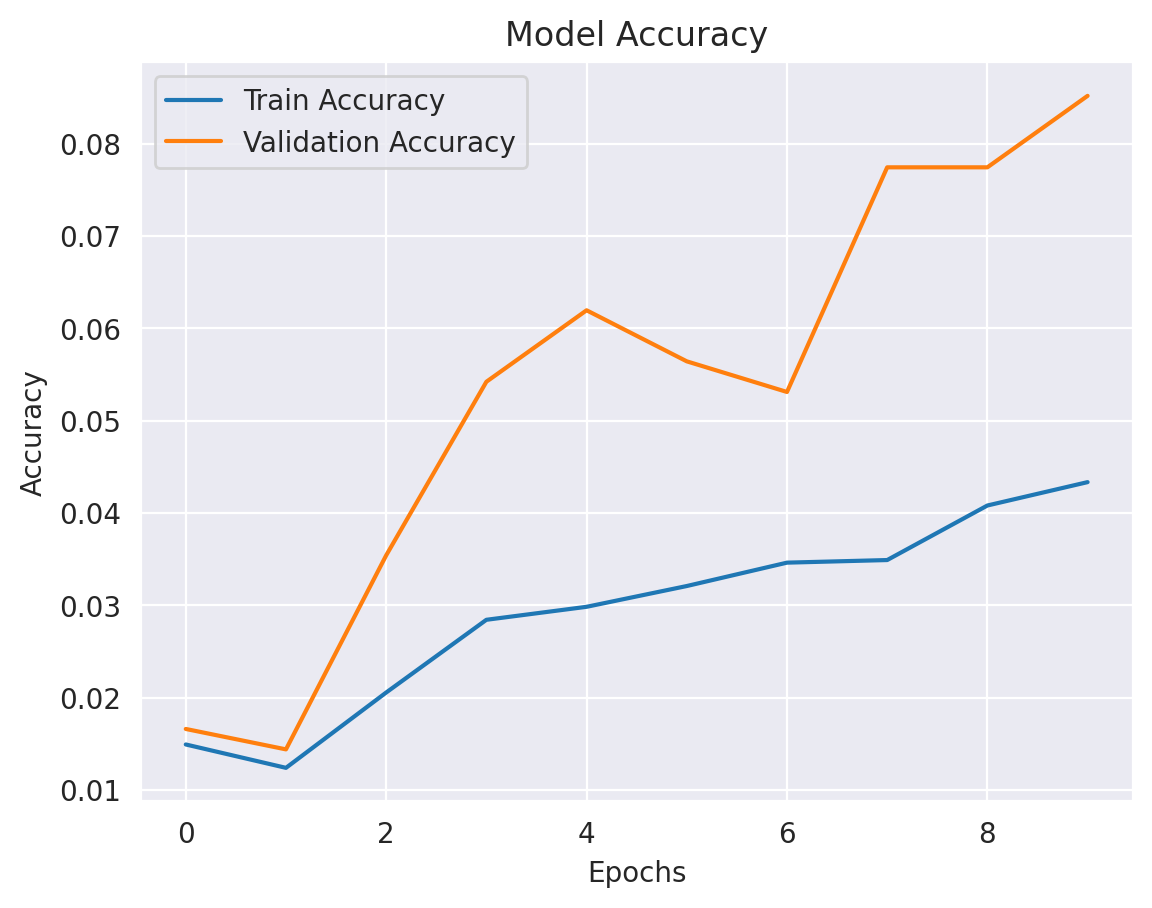

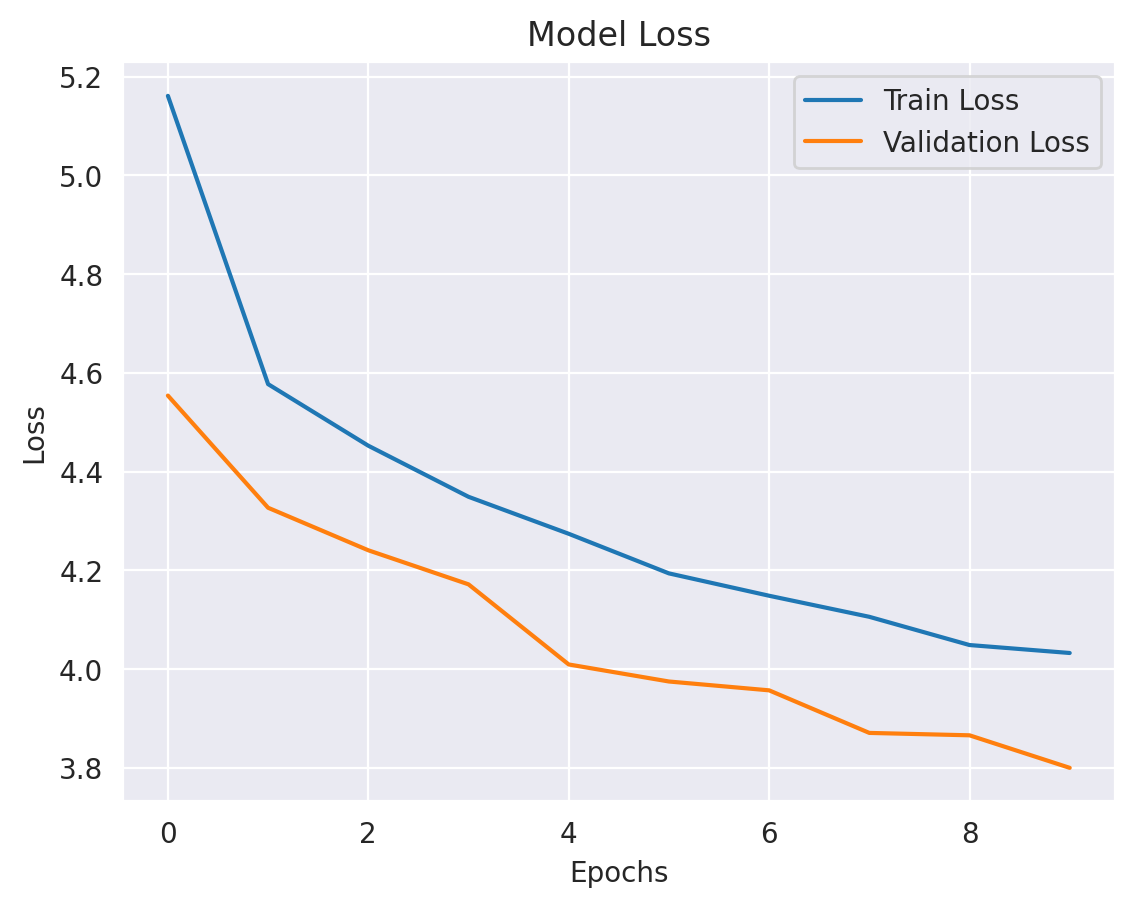

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def predict_pipeline_url(image_url):
    # get the image from the url
    response = requests.get(image_url)

    # Define the input image size
    input_shape = (224, 224)

    # load image data
    img = load_img(BytesIO(response.content), target_size=input_shape)

    # convert image to array
    x = img_to_array(img)

    # preprocess the image using efficientnet preprocessor
    x = preprocess_input(x)

    # Make the prediction
    preds = model.predict(np.array([x]))

    # get the index of the predicted class
    index = np.argmax(preds)

    # get the predicted class name
    predicted_class = labels[index]

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


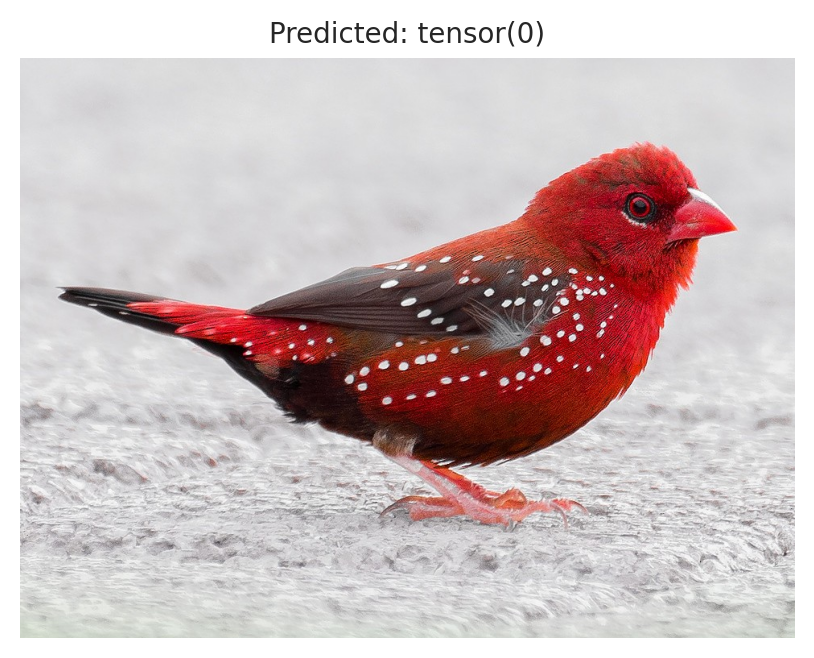

In [ ]:
predict_bird_from_URL('https://cdn.download.ams.birds.cornell.edu/api/v1/asset/78541101/1200')

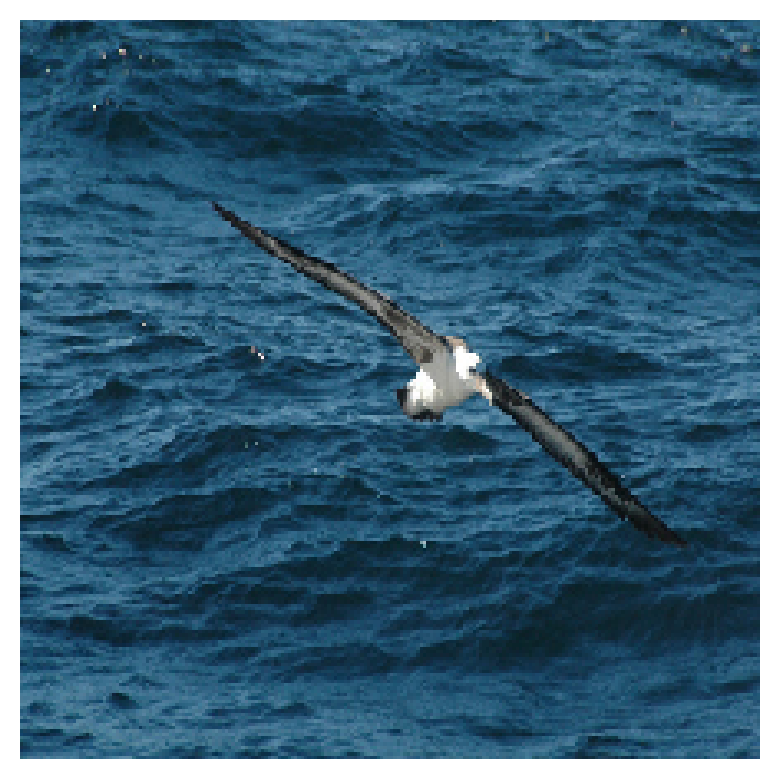

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Bird Species: 071.Long_tailed_Jaeger
Confidence: 0.05


('071.Long_tailed_Jaeger', 0.051930156)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_bird_from_drive(image_path, model, class_names):
    # Load the image
    img = image.load_img(image_path, target_size=(224, 224))  # Adjust size based on your model
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    print(f"Predicted Bird Species: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    return predicted_class, confidence

# Example usage
image_path = "/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0012_696.jpg"  # Replace with your image path
predict_bird_from_drive(image_path, model, class_names)


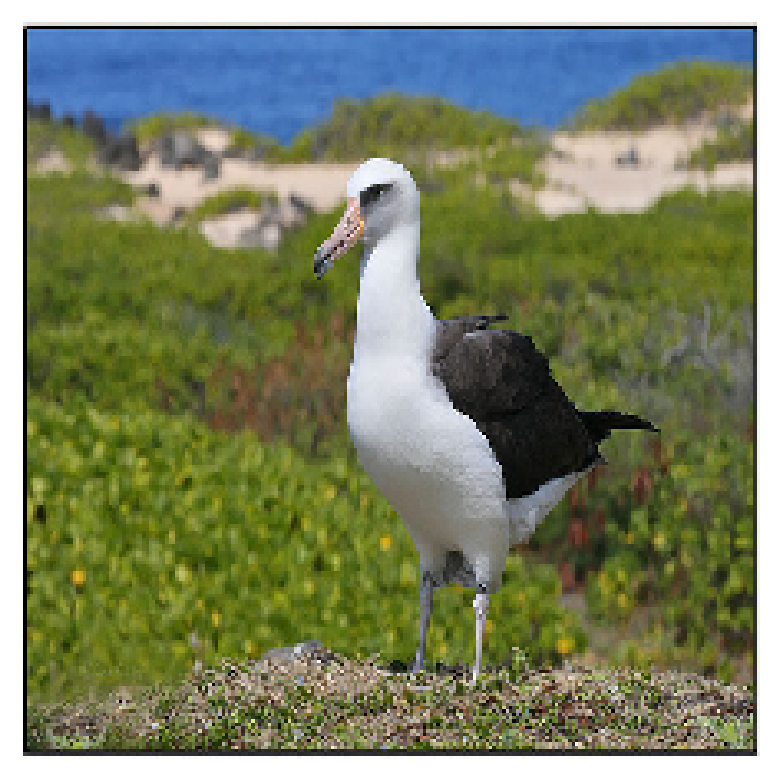

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Bird Species: 030.Fish_Crow
Confidence: 0.04


('030.Fish_Crow', 0.04128076)

In [ ]:
image_path = "/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/002.Laysan_Albatross/Laysan_Albatross_0034_628.jpg"  # Replace with your image path
predict_bird_from_drive(image_path, model, class_names)

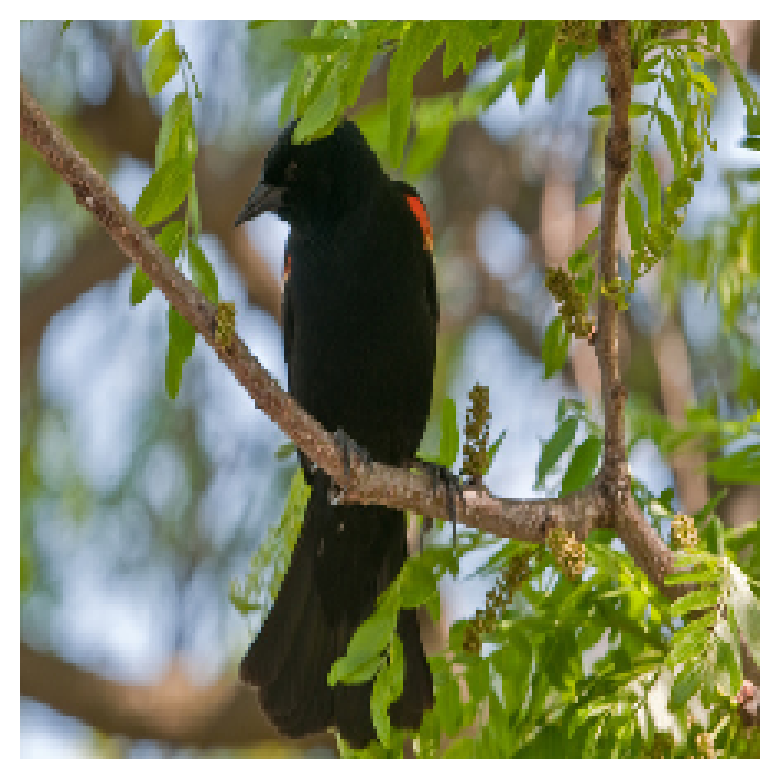

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Bird Species: 030.Fish_Crow
Confidence: 0.05


('030.Fish_Crow', 0.045781802)

In [ ]:
image_path = "/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/010.Red_winged_Blackbird/Red_Winged_Blackbird_0005_5636.jpg"  # Replace with your image path
predict_bird_from_drive(image_path, model, class_names)

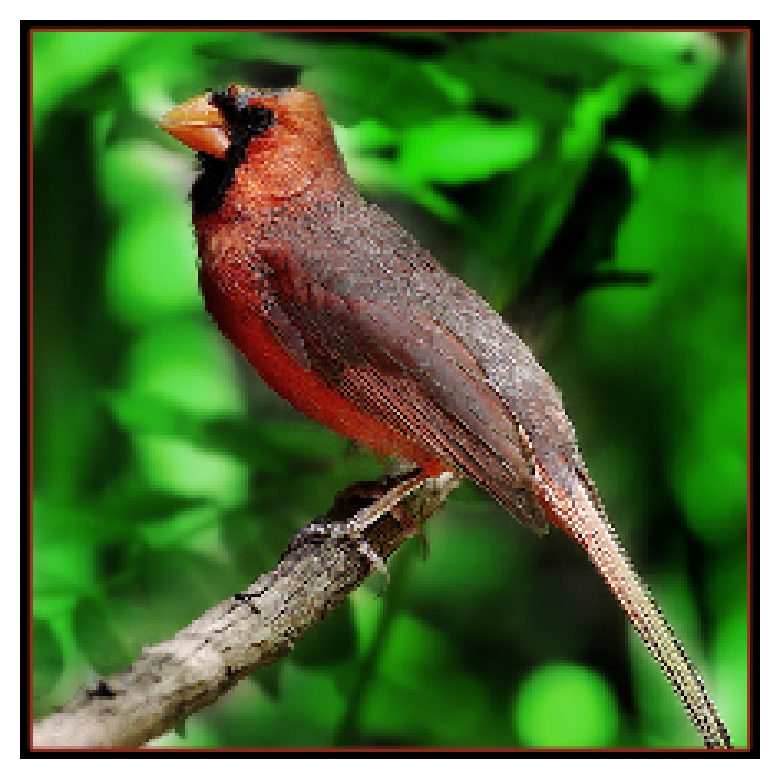

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Bird Species: 033.Yellow_billed_Cuckoo
Confidence: 0.12


('033.Yellow_billed_Cuckoo', 0.1161696)

In [ ]:
image_path = "/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/017.Cardinal/Cardinal_0001_17057.jpg"  # Replace with your image path
predict_bird_from_drive(image_path, model, class_names)

In [ ]:
from tensorflow.keras.models import load_model

# Update the model_path to point to the location where you saved the model
model_path = '/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5'

# Load your model
model = load_model(model_path)

# Check the input shape
print("Model Input Shape:", model.input_shape)

# Print the model summary
model.summary()

Model Input Shape: (None, 224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,484 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Your previous code for data loading and preprocessing) ...

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescale validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Define the train_dir and val_dir variables before using them
train_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/train'  # Replace with your actual train directory
val_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/val'  # Replace with your actual validation directory


# Load data from directories
train_generator = train_datagen.flow_from_directory(  # Make sure this line is executed
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'
)

# ... (Your code for model creation and training) ...

# Assuming train_generator was created using flow_from_directory
labels = (train_generator.class_indices)  # Now train_generator should be defined
labels = dict((v, k) for k, v in labels.items())


Found 3554 images belonging to 210 classes.
Found 904 images belonging to 210 classes.


In [ ]:
import os

# Set the path to the directory containing the bird species folders
dataset_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images'
# Get the class labels by listing the directory names
class_labels = os.listdir(dataset_dir)

# Display the class labels
print("Class labels:", class_labels)


Class labels: ['002.Laysan_Albatross', '001.Black_footed_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '006.Least_Auklet', '008.Rhinoceros_Auklet', '005.Crested_Auklet', '007.Parakeet_Auklet', '014.Indigo_Bunting', '012.Yellow_headed_Blackbird', '009.Brewer_Blackbird', '013.Bobolink', '011.Rusty_Blackbird', '010.Red_winged_Blackbird', '016.Painted_Bunting', '015.Lazuli_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '021.Eastern_Towhee', '020.Yellow_breasted_Chat', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '028.Brown_Creeper', '026.Bronzed_Cowbird', '025.Pelagic_Cormorant', '027.Shiny_Cowbird', '032.Mangrove_Cuckoo', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '036.Northern_Flicker', '034.Gray_crowned_Rosy_Finch', '033.Yellow_billed_Cuckoo', '038.Great_Crested_Flycatcher', '035.Purple_Finch', '037.Acadian_Flycatcher', '041.Scissor_tailed_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatc

In [ ]:
import tensorflow as tf # Import tensorflow if not already imported

# Load the model using load_model
model = tf.keras.models.load_model('/content/drive/MyDrive/Bird Species Classification/bird_species_model.h5')

In [ ]:
import pickle

try:
    with open('/content/drive/MyDrive/Bird Species Classification/bird_species_model.h5', 'rb') as file:
        model = pickle.load(file)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Error loading model: invalid load key, 'H'.


In [ ]:
!pip install tensorflow==<version_used_for_saving>
!pip install keras==<version_used_for_saving>


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install tensorflow==<version_used_for_saving>'
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install keras==<version_used_for_saving>'


In [ ]:
!pip install tensorflow


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


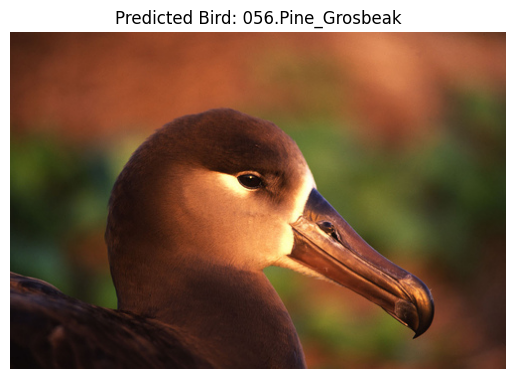

Predicted Bird Name: 056.Pine_Grosbeak


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
# Update with the correct path where you saved your model
model_path = '/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5'
model = tf.keras.models.load_model(model_path)


# Load and preprocess the image
def preprocess_image(img_path):
    IMAGE_SIZE = (224, 224)  # Change this if your model expects a different size
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict the bird species
def predict_bird_species(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return predicted_class_index, predictions

img_path = '/content/Black_Footed_Albatross_0031_100.jpg'  # Adjust path if needed

# Load bird labels from a text file or define them based on your dataset structure
# Example: If you have a text file named 'bird_labels.txt' in your Google Drive:
import os
dataset_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images'
bird_labels = sorted(os.listdir(dataset_dir))
# Ensure this list has 200 names corresponding to your model's output classes

# Predict
predicted_class_index, predictions = predict_bird_species(model, img_path)

# Display the image and prediction
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Bird: {bird_labels[predicted_class_index]}")  # Now with the correct labels
plt.show()

print(f"Predicted Bird Name: {bird_labels[predicted_class_index]}")  # Now with the correct labels



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


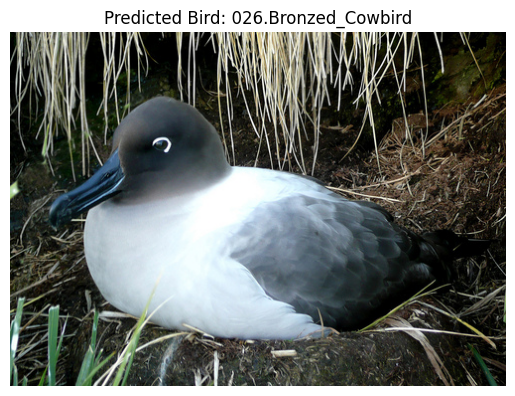

Predicted Bird Name: 026.Bronzed_Cowbird


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
# Update with the correct path where you saved your model
model_path = '/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5'
model = tf.keras.models.load_model(model_path)


# Load and preprocess the image
def preprocess_image(img_path):
    IMAGE_SIZE = (224, 224)  # Change this if your model expects a different size
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict the bird species
def predict_bird_species(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return predicted_class_index, predictions

img_path = '/content/Sooty_Albatross_0003_1078.jpg'  # Adjust path if needed

# Load bird labels from a text file or define them based on your dataset structure
# Example: If you have a text file named 'bird_labels.txt' in your Google Drive:
import os
dataset_dir = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images'
bird_labels = sorted(os.listdir(dataset_dir))
# Ensure this list has 200 names corresponding to your model's output classes

# Predict
predicted_class_index, predictions = predict_bird_species(model, img_path)

# Display the image and prediction
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Bird: {bird_labels[predicted_class_index]}")  # Now with the correct labels
plt.show()

print(f"Predicted Bird Name: {bird_labels[predicted_class_index]}")  # Now with the correct labels



In [ ]:
def preprocess_image(img_path):
    IMAGE_SIZE = (224, 224)  # Adjust to your model's input size
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [ ]:
import pandas as pd
import os  # Import the os module

# ... (Your previous code for loading the model and preprocessing images) ...

# Define a list of image paths
img_paths = ['/content/Black_Footed_Albatross_0031_100.jpg', '/content/Sooty_Albatross_0003_1078.jpg']  # Add more image paths as needed

# ... (Your previous code for predicting bird species) ...

results = []
for img_path in img_paths:  # Now you're iterating over the defined list of image paths
    img_array = preprocess_image(img_path)
    predicted_class_index, _ = predict_bird_species(model, img_path)
    results.append({'Image': img_path, 'Predicted Bird': bird_labels[predicted_class_index]})

df = pd.DataFrame(results)
df.to_csv('predictions.csv', index=False)
print("Results saved to predictions.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Results saved to predictions.csv


In [ ]:
import tensorflow as tf # Import tensorflow

# Load the model using load_model
model = tf.keras.models.load_model('/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5')  # Update with your model path

# Get input shape directly using model.input_shape
input_shape = model.input_shape

# Create a symbolic input (excluding batch size) - the first dimension is the batch size
symbolic_input = tf.keras.Input(shape=input_shape[1:])

# Call the first layer with the symbolic input to get its symbolic output
symbolic_output = model.layers[0](symbolic_input)

# Get the shape of the symbolic output
output_shape = symbolic_output.shape

# Print the output shape
print("Output shape of the first layer:", output_shape)

Output shape of the first layer: (None, 222, 222, 32)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
print("Output shape after first Conv2D:", model.layers[-1].output.shape) # Access output shape through .output

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))
print("Output shape after first MaxPooling2D:", model.layers[-1].output.shape) # Access output shape through .output

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
print("Output shape after second Conv2D:", model.layers[-1].output.shape) # Access output shape through .output

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))
print("Output shape after second MaxPooling2D:", model.layers[-1].output.shape) # Access output shape through .output

# Flatten layer
model.add(layers.Flatten())
print("Output shape after Flatten:", model.layers[-1].output.shape) # Access output shape through .output

# Dense layer
model.add(layers.Dense(128, activation='relu'))
print("Output shape after Dense layer:", model.layers[-1].output.shape) # Access output shape through .output

# Dropout layer
model.add(layers.Dropout(0.5))

# Final Dense layer
model.add(layers.Dense(210, activation='softmax'))
print("Output shape after final Dense layer:", model.layers[-1].output.shape) # Access output shape through .output

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Output shape after first Conv2D: (None, 222, 222, 32)
Output shape after first MaxPooling2D: (None, 111, 111, 32)
Output shape after second Conv2D: (None, 109, 109, 64)
Output shape after second MaxPooling2D: (None, 54, 54, 64)
Output shape after Flatten: (None, 186624)
Output shape after Dense layer: (None, 128)
Output shape after final Dense layer: (None, 210)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
import numpy as np

# Change the model path to the Google Drive path where the model was saved
model_path = '/content/drive/MyDrive/Bird Species Classification/manasa/bird_species_model.h5'
model = tf.keras.models.load_model(model_path)

# Create a dummy input to pass through the model
test_input = np.zeros((1, 224, 224, 3))  # Shape of the input image

for layer in model.layers:
    test_input = layer(test_input)
    print(f"Layer: {layer.name}, Output Shape: {test_input.shape}")

Layer: conv2d, Output Shape: (1, 222, 222, 32)
Layer: max_pooling2d, Output Shape: (1, 111, 111, 32)
Layer: conv2d_1, Output Shape: (1, 109, 109, 64)
Layer: max_pooling2d_1, Output Shape: (1, 54, 54, 64)
Layer: flatten, Output Shape: (1, 186624)
Layer: dense, Output Shape: (1, 128)
Layer: dropout, Output Shape: (1, 128)
Layer: dense_1, Output Shape: (1, 210)


In [ ]:
from PIL import Image  # Import the Image class from PIL

# Assign a valid file path to the 'filepath' variable
filepath = '/content/Sooty_Albatross_0001_1071.jpg'  # Replace with your actual image path

image = Image.open(filepath).convert('RGB')
image = image.resize((224, 224))  # Resize image to 224x224 as expected by the model
image_array = np.array(image) / 255.0  # Normalize the image pixels
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

In [ ]:
image = Image.open(filepath).convert('RGB')
image = image.resize((224, 224))  # Ensure it matches the model's expected input size


In [ ]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Output Shape: {layer.output.shape}") # Access the output shape through the 'output' property

Layer: conv2d, Output Shape: (None, 222, 222, 32)
Layer: max_pooling2d, Output Shape: (None, 111, 111, 32)
Layer: conv2d_1, Output Shape: (None, 109, 109, 64)
Layer: max_pooling2d_1, Output Shape: (None, 54, 54, 64)
Layer: flatten, Output Shape: (None, 186624)
Layer: dense, Output Shape: (None, 128)
Layer: dropout, Output Shape: (None, 128)
Layer: dense_1, Output Shape: (None, 210)


In [ ]:
print(model.layers[4].output.shape)  # Access the output shape through the 'output' property

(None, 186624)


In [ ]:
model.add(layers.Dense(128, input_dim=186624, activation='relu'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Update the Dense layer to match the flattened output shape
model.add(layers.Dense(128, activation='relu'))  # If flattened output is 186624
model.add(layers.Dropout(0.5))

# Final output layer with 210 classes
model.add(layers.Dense(210, activation='softmax'))  # Assuming you have 210 output classes

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,482 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(model.layers[5].input.shape)  # Access the input shape through the 'input' property

(None, 186624)


In [ ]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Output Shape: {layer.output.shape}") # Use layer.output.shape

Layer: conv2d_3, Output Shape: (None, 222, 222, 32)
Layer: max_pooling2d_2, Output Shape: (None, 111, 111, 32)
Layer: conv2d_4, Output Shape: (None, 109, 109, 64)
Layer: max_pooling2d_3, Output Shape: (None, 54, 54, 64)
Layer: flatten_1, Output Shape: (None, 186624)
Layer: dense_3, Output Shape: (None, 128)
Layer: dropout_1, Output Shape: (None, 128)
Layer: dense_4, Output Shape: (None, 210)


In [ ]:
model.add(layers.Dense(128, input_dim=186624, activation='relu'))


In [ ]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 210)                 │          27,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          27,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,978,002 (91.47 MB)

 Trainable params: 23,978,002 (91.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# MaxPooling layer
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Ensure the input shape of the Dense layer matches the flatten output size
model.add(layers.Dense(128, activation='relu'))  # input_dim=186624 if needed
model.add(layers.Dropout(0.5))

# Final output layer with 210 classes
model.add(layers.Dense(210, activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,482 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
test_input = np.zeros((1, 224, 224, 3))  # Shape of the input image
output = model.predict(test_input)
print(f"Prediction Output: {output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction Output: [[0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619 0.0047619
  0.00476

In [ ]:
model.summary()

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras import layers, models

# Define the model (if not already defined)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(210, activation='softmax'))  # Assuming 210 classes

# Now you can call summary()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,482 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values
train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images',  # Replace with the actual path to your dataset
    target_size=(224, 224),  # Resize to 224x224
    batch_size=32,
    class_mode='categorical'
)

Found 4458 images belonging to 210 classes.


In [ ]:
for images, labels in train_data:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 210)


In [ ]:
from tensorflow.keras import layers, models

# Create a new Sequential model
model = models.Sequential()

# Add your layers in the desired order
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(210, activation='softmax'))  # Assuming 210 classes

# Now you can call summary()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,482 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images',  # Replace 'path_to_dataset' with the actual path to your dataset
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4458 images belonging to 210 classes.


In [ ]:
model.save('/content/drive/MyDrive/Bird Species Classification/manasa/bsmodel.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    IMAGE_SIZE = (222, 222)  # Match this with your model's input size
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [ ]:
# Example image path
image_path = '/content/Gray_Catbird_0019_20567.jpg'

# Preprocess and verify the image
img_array = preprocess_image(image_path)
print("Image shape after preprocessing:", img_array.shape)


Image shape after preprocessing: (1, 222, 222, 3)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(222, 222, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(210, activation='softmax'))  # Assuming 210 classes

# Print the model summary to verify
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,934,482 (91.30 MB)

 Trainable params: 23,934,482 (91.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os

dataset_path = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images'
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    break  # Check just the top level


Directory: /content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images
Subdirectories: ['002.Laysan_Albatross', '001.Black_footed_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '006.Least_Auklet', '008.Rhinoceros_Auklet', '005.Crested_Auklet', '007.Parakeet_Auklet', '014.Indigo_Bunting', '012.Yellow_headed_Blackbird', '009.Brewer_Blackbird', '013.Bobolink', '011.Rusty_Blackbird', '010.Red_winged_Blackbird', '016.Painted_Bunting', '015.Lazuli_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '021.Eastern_Towhee', '020.Yellow_breasted_Chat', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '028.Brown_Creeper', '026.Bronzed_Cowbird', '025.Pelagic_Cormorant', '027.Shiny_Cowbird', '032.Mangrove_Cuckoo', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '036.Northern_Flicker', '034.Gray_crowned_Rosy_Finch', '033.Yellow_billed_Cuckoo', '038.Great_Crested_Flycatcher', '035.Purple_Finch', '037.Acadian_Fly

In [ ]:
import os

dataset_path = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images'
for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        files = os.listdir(class_folder_path)
        print(f"Class folder: {class_folder}")
        print(f"Number of files: {len(files)}")
        if files:
            print(f"Sample file: {files[0]}")
        print("-" * 50)


Class folder: 002.Laysan_Albatross
Number of files: 60
Sample file: Laysan_Albatross_0044_784.jpg
--------------------------------------------------
Class folder: 001.Black_footed_Albatross
Number of files: 60
Sample file: Black_Footed_Albatross_0010_796097.jpg
--------------------------------------------------
Class folder: 003.Sooty_Albatross
Number of files: 58
Sample file: Sooty_Albatross_0074_1221.jpg
--------------------------------------------------
Class folder: 004.Groove_billed_Ani
Number of files: 60
Sample file: Groove_Billed_Ani_0044_1731.jpg
--------------------------------------------------
Class folder: 006.Least_Auklet
Number of files: 41
Sample file: Least_Auklet_0058_1931.jpg
--------------------------------------------------
Class folder: 008.Rhinoceros_Auklet
Number of files: 48
Sample file: Rhinoceros_Auklet_0032_797516.jpg
--------------------------------------------------
Class folder: 005.Crested_Auklet
Number of files: 44
Sample file: Crested_Auklet_0057_79493

In [ ]:
import zipfile

# Update the dataset_zip_path to include 'manasa' in the path
dataset_zip_path = '/content/drive/MyDrive/Bird Species Classification/archive.zip'
extract_path = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011'

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset re-extracted successfully!")

Dataset re-extracted successfully!


In [ ]:
import os

# Make sure to update with your actual file path
dataset_zip_path = '/content/drive/MyDrive/Bird Species Classification/archive.zip'

# Check if the file exists
if os.path.exists(dataset_zip_path):
    # Check file size
    size_in_bytes = os.path.getsize(dataset_zip_path)
    size_in_mb = size_in_bytes / (1024 * 1024)

    if size_in_mb == 0:
        print(f"Warning: File at {dataset_zip_path} is empty (0 MB).")
        # Check if it's a directory
        if os.path.isdir(dataset_zip_path):
            print(f"The path {dataset_zip_path} is a directory, not a file.")
        else:
            print("The file might be corrupted or empty.")
    else:
        print(f"Dataset size: {size_in_mb:.2f} MB")
else:
    print(f"Error: File not found at {dataset_zip_path}. "
          f"Please double-check the path and make sure Google Drive is mounted.")

Dataset size: 0.00 MB


In [ ]:
import os

# Update the path to reflect the correct location of the dataset ZIP file
dataset_zip_path = '/content/drive/MyDrive/Bird Species Classification/archive.zip'  # Assuming this is the correct path

# Verify the file exists before attempting to get its size
if os.path.exists(dataset_zip_path):
    print(f"Dataset size: {os.path.getsize(dataset_zip_path) / (1024 * 1024):.2f} MB")
else:
    print(f"Error: File not found at {dataset_zip_path}")

Dataset size: 0.00 MB


In [ ]:
for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        for file in os.listdir(class_folder_path):
            file_path = os.path.join(class_folder_path, file)
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                new_file_path = file_path + '.jpg'  # Add .jpg extension
                os.rename(file_path, new_file_path)
                print(f"Renamed {file_path} to {new_file_path}")
print("File renaming completed!")


File renaming completed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        files = os.listdir(class_folder_path)
        print(f"Class folder: {class_folder}")
        print(f"Number of files: {len(files)}")
        if files:
            print(f"Sample file: {files[0]}")
        print("-" * 50)


Class folder: 002.Laysan_Albatross
Number of files: 60
Sample file: Laysan_Albatross_0044_784.jpg
--------------------------------------------------
Class folder: 001.Black_footed_Albatross
Number of files: 60
Sample file: Black_Footed_Albatross_0010_796097.jpg
--------------------------------------------------
Class folder: 003.Sooty_Albatross
Number of files: 58
Sample file: Sooty_Albatross_0074_1221.jpg
--------------------------------------------------
Class folder: 004.Groove_billed_Ani
Number of files: 60
Sample file: Groove_Billed_Ani_0044_1731.jpg
--------------------------------------------------
Class folder: 006.Least_Auklet
Number of files: 41
Sample file: Least_Auklet_0058_1931.jpg
--------------------------------------------------
Class folder: 008.Rhinoceros_Auklet
Number of files: 48
Sample file: Rhinoceros_Auklet_0032_797516.jpg
--------------------------------------------------
Class folder: 005.Crested_Auklet
Number of files: 44
Sample file: Crested_Auklet_0057_79493

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_path = '/content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/001.Black_footed_Albatross'
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


FileNotFoundError: Couldn't find any class folder in /content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/001.Black_footed_Albatross.

FileNotFoundError: No image files found in class subdirectory: /content/drive/MyDrive/Bird Species Classification/manasa/CUB_200_2011/images/077.Tropical_Kingbird